In [ ]:
import os
os.environ["SPS_HOME"] = "/Users/ncv375/Desktop/Year1/spatialSED/quick_repo_natalia/fsps"
from sbipix import sbipix
from sbipix import *
from sbipix.plotting.diagnostics  import plot_filters, plot_theta, plot_test_performance

# Create SBIPIX instance
sx = sbipix()

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [2]:
# Configure for JADES
sx.filter_path = './obs/obs_properties/'
sx.filter_list='filters_jades_no_wfc.dat'
sx.atlas_name = 'atlas_obs_jades_tau_GSz14test'
sx.n_simulation = 100000
sx.parametric = True  # or False for non-parametric SFH
sx.both_masses = True
sx.infer_z = True
sx.infer_onlyz = True

In [6]:
sx.simulate(
    mass_max=12, mass_min=4.0,
    z_prior='flat', z_min=0.0, z_max=20.0,
    Z_min=-2.27, Z_max=0.4,
    dust_model='Calzetti',
    Av_min=0.0, Av_max=4.0
)

Generating parametric (τ-delayed) SFH atlas...
Generating atlas with:
N_pregrid: 100000, Parametric SFH (delayed-tau model)


Generating parametric SEDs: 100%|██████████| 100000/100000 [48:53<00:00, 34.09it/s] 


Path exists. Saved atlas at: ./library/atlas_obs_jades_tau_GSz14test_100000_Nparam_2.dbatlas


In [3]:
sx.remove_filters=[7, 10, 12, 13]
sx.load_simulation()

(array([[193.59584222, 193.59584222,  68.09014418, ..., 193.59584222,
         193.59584222, 193.59584222],
        [ 25.59587665,  24.87250913,  24.54980963, ...,  26.25781805,
          26.00621512,  25.60847444],
        [ 33.1819959 ,  32.01224504,  31.06444678, ...,  37.22241029,
          34.25815776,  33.04502568],
        ...,
        [ 22.12749381,  21.27158132,  20.90808869, ...,  22.03941941,
          22.019091  ,  22.07352045],
        [ 26.72513655,  25.67644211,  25.33785526, ...,  27.50204187,
          27.25487831,  26.75161318],
        [193.46576848, 172.35060651,  56.30376692, ..., 193.46576848,
         193.46576848, 193.46576848]], shape=(100000, 19)),
 array([[ 7.45769323,  7.45869299,  0.0304    , ..., -1.30652183,
          1.52539139, 14.30678463],
        [10.26250823, 10.45176836,  1.09295993, ..., -2.02430338,
          1.57124858,  1.55749385],
        [10.53296896, 10.63363792,  2.39435108, ..., -2.05982431,
          3.16243765,  6.06548807],
        ...

In [4]:
sx.include_limit = True
sx.condition_sigma = True
sx.include_sigma = True
sx.load_obs_features()
sx.add_noise_nan_limit_all()

Observational features loaded


Adding observational realism: 100%|██████████| 100000/100000 [02:45<00:00, 605.39it/s]


In [5]:
print('pre-filter', len(sx.mag))


pre-filter 100000


In [6]:
sim_ok=np.isfinite(np.sum(sx.theta,axis=1))
mass_ok=(sx.theta[sim_ok,1]>=4.0)
sx.theta=sx.theta[sim_ok,:][mass_ok,:]
sx.mag=sx.mag[sim_ok,:,:][mass_ok,:,:]
sx.obs=sx.obs[sim_ok,:][mass_ok,:]
sx.n_simulation=len(sx.theta[:,0])

In [7]:
print('post-filter', len(sx.mag))


post-filter 99753


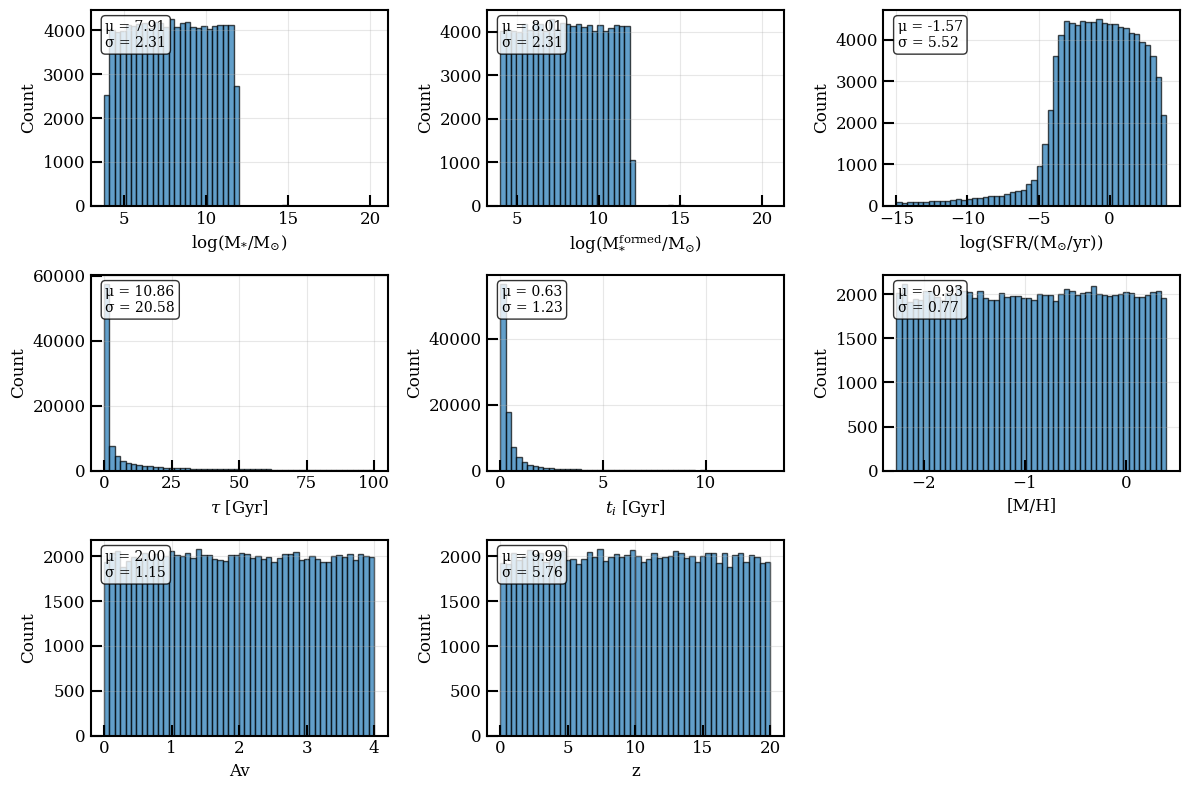

In [8]:
plot_theta(sx,limit_sfr=True,range_sfr=(-15,4))

In [9]:
sx.model_name = 'post_obs_jades_tau_GSz14test.pkl' 

In [10]:
# max_values = np.max(sx.theta[:, :], axis=0)     
# min_values = np.min(sx.theta[:, :], axis=0)  
max_values = [np.max(sx.theta[:, -1])]
min_values = [np.min(sx.theta[:, -1])]
print(min_values)                               
print(max_values)

[np.float64(6.378431288034392e-05)]
[np.float64(19.999738912777644)]


In [11]:
sx.theta[:, -1:].shape

(99753, 1)

In [12]:
sx.obs.shape

(99753, 19)

In [13]:
sx.train(
    min_thetas=min_values,
    max_thetas=max_values,
    n_max=len(sx.theta),
    nblocks=5,
    nhidden=128
)

Lower bounds: tensor([6.3784e-05])
Upper bounds: tensor([19.9997])
 Neural network successfully converged after 145 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 145
        Best validation performance: 2.2490
        -------------------------
        
Model saved to ./library/post_obs_jades_tau_GSz14test.pkl


In [14]:
posterior_test = sx.test_performance(
    n_test = 10000,                
    return_posterior = True
)

Testing performance: 100%|██████████| 10000/10000 [00:42<00:00, 236.32it/s]


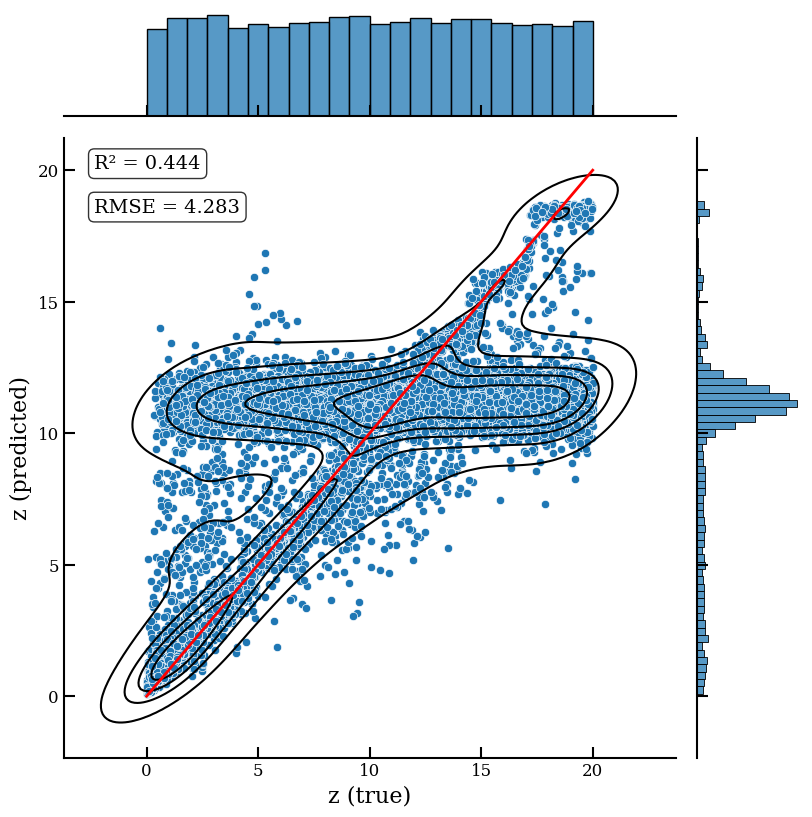

In [15]:
plot_test_performance(sx,n_test = 10000)